In [1]:
# noise sources: stellar flux variations, orientiation angle noise, telescope polarization

# fitting params: (albedo*polarization fraction), {Omega, inclination} or {apparent inc, orbAxisAng angle}
# additional real params: Q+U+V offsets

# need to do a disk integration since there isn't a single path that light takes
#    - need to account for angles spanning the visible portion of the illuminated hemisphere

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import EPPE_Simulator as eppe
import astropy.constants as const

from EPPE_Simulator import cross_match
cross_match.cross_match_tables()

In [3]:
expTime = 1
intTime = 30*24.

randomOrientation = False
albedo = 0.1#0.1#'theo'
polEff = 1.
filt = 'V'
pNoiseMultiplier = 1.8

savePlots = True
savepath = 'saves/'

In [4]:
systems = eppe.Systems(load=True, polEff=polEff, randomOrientation=randomOrientation, albedo=albedo)

systems.catalogue['albedo'][systems.catalogue['rp']/const.R_earth.value<6.] = 0.3

# mission = eppe.mission(systems, rad=0.8, filt=filt, trans=0.9) # POMM
mission = eppe.mission(systems, filt=filt, trans=0.9, usePhoenix=True) # EPPE

In [5]:
teq = systems.catalogue['teq']
rps = systems.catalogue['rp']

amps = mission.compute_amps()
noise = mission.compute_noise(expTime)*pNoiseMultiplier
SNRs = mission.compute_SNR(amps=amps, noise=noise)
_, fstar, _ = mission.expose_photometric(expTime, rnd=False)

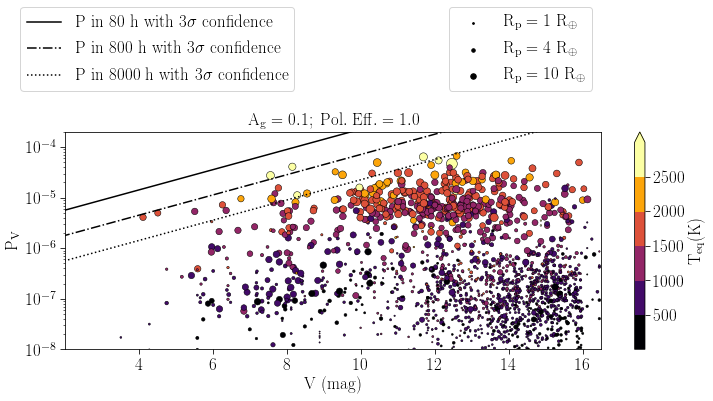

In [6]:
fig = plt.figure(figsize=(12,4))

cmap = plt.get_cmap('inferno', 6)

# good = rps/const.R_earth.value >= 6.
# good = teq < 2000
good = teq > -1

# additive offset found using median approxMag-optMag
approxMag = -2.5*np.log10(fstar) + 27.290663305524518
optMag = systems.catalogue['optMag']

plt.scatter(x=optMag[good], y=amps[good], c=teq[good], s=3*rps[good]/const.R_earth.value, cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
cbar = plt.colorbar(label=r'$\rm T_{eq} (K)$', extend='max')
cbar.set_ticks([500,1000,1500,2000,2500])

noiseFloor = 0#1e-7*3*np.sqrt(2)
x = np.linspace(0,20,1000)

tint = 80
limit = 1/np.sqrt(tint/expTime)*3*np.sqrt(2)*noise[np.argmin(approxMag)]*(10**((x-np.min(approxMag))/5))
limit += noiseFloor
limit *= 2 # multiplier for only measuring one polarization state at a time
limit *= 2 # multiplier for only 50% visibility from low-Earth, Sun-synchronous orbit
plt.plot(x, limit, c='k', ls='-', label=r'$\rm P~in~'+str(tint)+'~h~with~3\sigma~confidence$')

tint = 800
limit = 1/np.sqrt(tint/expTime)*3*np.sqrt(2)*noise[np.argmin(approxMag)]*(10**((x-np.min(approxMag))/5))
limit += noiseFloor
limit *= 2 # multiplier for only measuring one polarization state at a time
limit *= 2 # multiplier for only 50% visibility from low-Earth, Sun-synchronous orbit
plt.plot(x, limit, c='k', ls='-.', label=r'$\rm P~in~'+str(tint)+'~h~with~3\sigma~confidence$')

tint = 8000
limit = 1/np.sqrt(tint/expTime)*3*np.sqrt(2)*noise[np.argmin(approxMag)]*(10**((x-np.min(approxMag))/5))
limit += noiseFloor
limit *= 2 # multiplier for only measuring one polarization state at a time
limit *= 2 # multiplier for only 50% visibility from low-Earth, Sun-synchronous orbit
plt.plot(x, limit, c='k', ls='dotted', label=r'$\rm P~in~'+str(tint)+'~h~with~3\sigma~confidence$')


plt.yscale('log')
plt.ylim(1e-8,2e-4)
plt.xlim(2,16.5)
plt.xticks([4,6,8,10,12,14,16])

plt.xlabel(r'$\rm V~(mag)$')
plt.ylabel(r'$\rm P_'+filt+'$')
if albedo != 'theo':
    plt.title(r'$\rm A_g = '+str(albedo)+';~Pol.~Eff. = '+str(polEff)+'$')
else:
    plt.title(r'$\rm Predicted~A_g;~Pol.~Eff. = '+str(polEff)+'$')

rp = 1
d1 = plt.scatter(x=1000, y=1e-12, c='k', s=3*rp, label=r'$\rm R_p = '+str(rp)+'~R_{\oplus}$')
rp = 4
d2 = plt.scatter(x=1000, y=1e-12, c='k', s=3*rp, label=r'$\rm R_p = '+str(rp)+'~R_{\oplus}$')
rp = 10
d3 = plt.scatter(x=1000, y=1e-12, c='k', s=3*rp, label=r'$\rm R_p = '+str(rp)+'~R_{\oplus}$')

handles, labels = plt.gca().get_legend_handles_labels()
legend1 = plt.legend(handles[:3], labels[:3], loc=3, bbox_to_anchor=(-0.1,1.15))
legend2 = plt.legend(handles[3:], labels[3:], loc=3, bbox_to_anchor=(0.7,1.15))
plt.gca().add_artist(legend1)

if savePlots:
    if albedo=='theo':
        plt.savefig(savepath+'PV_vs_V_theoAg.png', dpi=300, bbox_inches='tight')
    else:
        plt.savefig(savepath+'PV_vs_V.png', dpi=300, bbox_inches='tight')
plt.show()

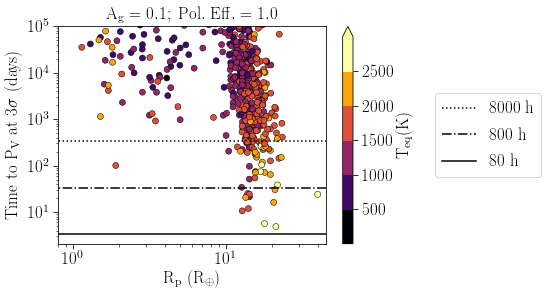

In [7]:
tint = 1
limit = 1/np.sqrt(tint/expTime)*3*np.sqrt(2)*noise[np.argmin(approxMag)]*(10**((approxMag-np.min(approxMag))/5))

x = rps[good]/const.R_earth.value
tToThreeSig = (limit/amps)[good]**2/24.

tToThreeSig *= 2 # multiplier for only measuring one polarization state at a time
tToThreeSig *= 2 # multiplier for only 50% visibility from low-Earth, Sun-synchronous orbit

cmap = plt.get_cmap('inferno', 6)
plt.scatter(x, tToThreeSig, c=teq[good], cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
cbar = plt.colorbar(label=r'$\rm T_{eq} (K)$', extend='max')
cbar.set_ticks([500,1000,1500,2000,2500])

plt.plot([0,1e5], [8000/24.,8000/24.], c='k', ls='dotted', label=r'$\rm 8000~h$')
plt.plot([0,1e5], [800/24.,800/24.], c='k', ls='-.', label=r'$\rm 800~h$')
plt.plot([0,1e5], [80/24.,80/24.], c='k', ls='-', label=r'$\rm 80~h$')

plt.yscale('log')
plt.xscale('log')
plt.ylim(np.min([np.nanmin(tToThreeSig[tToThreeSig>0])/2., 50/24.]),1e5)
plt.xlim(8e-1,45)

if albedo != 'theo':
    plt.title(r'$\rm A_g = '+str(albedo)+';~Pol.~Eff. = '+str(polEff)+'$')
else:
    plt.title(r'$\rm Predicted~A_g;~Pol.~Eff. = '+str(polEff)+'$')
plt.ylabel(r'$\rm Time~to~P_'+filt+'~at~3\sigma~(days)$')
plt.xlabel(r'$\rm R_p~(R_{\oplus})$')

plt.legend(loc=6, bbox_to_anchor=(1.375,0.5))

if savePlots:
    if albedo=='theo':
        plt.savefig(savepath+'Stare_vs_Rp_theoAg.png', dpi=300, bbox_inches='tight')
    else:
        plt.savefig(savepath+'Stare_vs_Rp.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
nPlanets = 10
nEarths = 10
fullNames = np.array([])
fullInds = np.array([], dtype=int)

output = ''

if albedo == 'theo':
    output += 'Assuming predicted Ag, Pol. Eff. = '+str(polEff)+'\n\n\n'
else:
    output += 'Fixed depth in Ag, Pol. Eff. = '+str(polEff)+'\n\n\n'

for teqMin in range(0,3000,500):
    if teqMin<2500:
        teqMax = teqMin+500
    else:
        teqMax = np.inf
    inds = np.where(np.logical_and(np.logical_and(np.logical_and(teqMin <= teq, teq < teqMax), tToThreeSig<100), rps/const.R_earth.value>6))[0]
    inds = inds[np.argsort(tToThreeSig[inds])]
    if len(inds) > nPlanets:
        inds = inds[:nPlanets]
    names = systems.catalogue['name'][inds]
    ras = (24./360.*systems.catalogue['ra'][inds]).astype(str)
    decs = systems.catalogue['dec'][inds].astype(str)
    fullNames = np.append(fullNames, names)
    fullInds = np.append(fullInds, inds)
    output += str(teqMin)+' K < Teq <= '+str(teqMax)+' K\n'
    output += 'names = [\''+'\', \''.join(names)+'\']\n'
    output += 'RA = ['+', '.join(ras)+']\n'
    output += 'DEC = ['+', '.join(decs)+']\n'
    output += 'Teqs = ['+', '.join(np.rint(teq[inds]).astype(int).astype(str))+'] (K)\n'
    output += 'Rps = ['+', '.join(np.round(rps[inds]/const.R_jup.value,1).astype(str))+'] (R_jup)\n'
    output += 'Albedo = ['+', '.join((np.round(systems.catalogue['albedo'][inds], 2)).astype(str))+']\n'
    output += 'Time to 3 sig = ['+', '.join(np.round(tToThreeSig[inds],2).astype(str))+'] (days)\n\n'

output += '\nMax time to 3 sigma:    '+str(np.round(np.max(tToThreeSig[fullInds]), 2))+' days\n'
output += 'Mean time to 3 sigma:   '+str(np.round(np.mean(tToThreeSig[fullInds]), 2))+' days\n'
output += 'Median time to 3 sigma: '+str(np.round(np.median(tToThreeSig[fullInds]), 2))+' days\n'
output += 'Min time to 3 sigma:    '+str(np.round(np.min(tToThreeSig[fullInds]), 2))+' days\n\n\n'
output += ('Total time to 3 sigma:  '+str(np.round(np.sum(tToThreeSig[fullInds]), 2))+' days'+
                                     ' ('+str(np.round(np.sum(tToThreeSig[fullInds])/365., 2))+' years)\n\n\n')
    
inds = np.where(np.logical_and(rps/const.R_earth.value < 6, tToThreeSig<100))[0]
inds = inds[np.argsort(tToThreeSig[inds])]
if len(inds) > nEarths:
    inds = inds[:nEarths]
if len(inds) != 0:
    names = systems.catalogue['name'][inds]
    ras = (24./360.*systems.catalogue['ra'][inds]).astype(str)
    decs = systems.catalogue['dec'][inds].astype(str)
    fullNames = np.append(fullNames, names)
    fullInds = np.append(fullInds, inds)
    output += 'Rp < 4 R_earth\n'
    output += 'names = [\''+'\', \''.join(names)+'\']\n'
    output += 'RA = ['+', '.join(ras)+']\n'
    output += 'DEC = ['+', '.join(decs)+']\n'
    output += 'Teqs = ['+', '.join(np.rint(teq[inds]).astype(int).astype(str))+'] (K)\n'
    output += 'Rps = ['+', '.join(np.round(rps[inds]/const.R_jup.value,1).astype(str))+'] (R_jup)\n'
    output += 'Albedo = ['+', '.join((np.round(systems.catalogue['albedo'][inds], 2)).astype(str))+']\n'
    output += 'Time to 3 sig = ['+', '.join(np.round(tToThreeSig[inds],2).astype(str))+'] (days)\n\n'

    output += '\nMax time to 3 sigma:    '+str(np.round(np.max(tToThreeSig[inds]), 2))+' days\n'
    output += 'Mean time to 3 sigma:   '+str(np.round(np.mean(tToThreeSig[inds]), 2))+' days\n'
    output += 'Median time to 3 sigma: '+str(np.round(np.median(tToThreeSig[inds]), 2))+' days\n'
    output += 'Min time to 3 sigma:    '+str(np.round(np.min(tToThreeSig[inds]), 2))+' days\n\n\n'
    output += ('Total time to 3 sigma:  '+str(np.round(np.sum(tToThreeSig[inds]), 2))+' days'+
                                         ' ('+str(np.round(np.sum(tToThreeSig[inds])/365., 2))+' years)\n\n\n')

output += ('Total Number of Targets: '+str(len(fullInds))+'\n')
output += ('Mission lifetime:  '+str(np.round(np.sum(tToThreeSig[fullInds])/365., 2))+' years\n\n\n')

fullNames = np.unique(fullNames)
fullInds = np.unique(fullInds)

print(output)

if savePlots:
    with open(savepath+'suggestedTargets.txt', "w") as text_file:
        text_file.write(output)

Fixed depth in Ag, Pol. Eff. = 1.0


0 K < Teq <= 500 K
names = ['']
RA = []
DEC = []
Teqs = [] (K)
Rps = [] (R_jup)
Albedo = []
Time to 3 sig = [] (days)

500 K < Teq <= 1000 K
names = ['']
RA = []
DEC = []
Teqs = [] (K)
Rps = [] (R_jup)
Albedo = []
Time to 3 sig = [] (days)

1000 K < Teq <= 1500 K
names = ['51 Peg b', 'HD 189733 b', 'HD 75289 b', 'HD 209458 b', 'HD 187123 b']
RA = [22.9577718, 20.01214193333334, 8.7945526, 22.052992733333333, 19.7828084]
DEC = [20.768833, 22.710854, -41.736794, 18.884319, 34.419525]
Teqs = [1333, 1192, 1463, 1477, 1467] (K)
Rps = [1.3, 1.1, 1.3, 1.4, 1.3] (R_jup)
Albedo = [0.1, 0.1, 0.1, 0.1, 0.1]
Time to 3 sig = [21.28, 34.1, 51.26, 74.52, 96.83] (days)

1500 K < Teq <= 2000 K
names = ['tau Boo b', 'ups And b', 'HD 212301 b', 'HD 179949 b', 'WASP-77 A b']
RA = [13.787706533333333, 1.6132896666666667, 22.45858966666667, 19.259230533333334, 2.4770076666666667]
DEC = [17.456905, 41.40546, -77.717926, -24.179352, -7.060681]
Teqs = [1685, 1530, 1871, 158

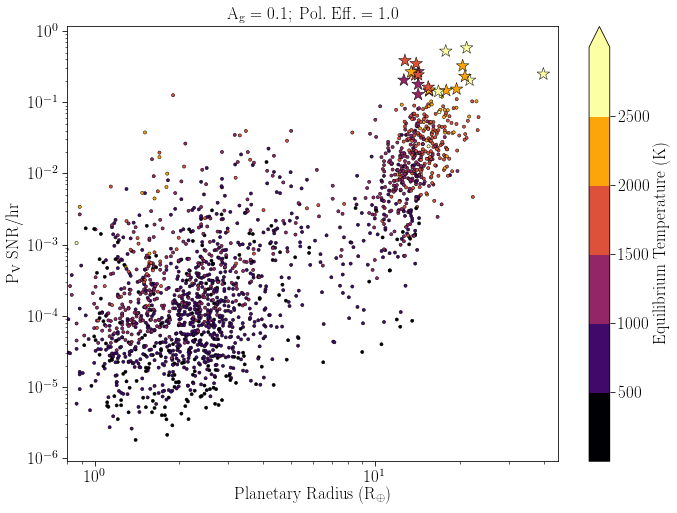

In [9]:
fig = plt.figure(figsize=(11,8))
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(np.nanmin(SNRs[SNRs>0])/2, np.nanmax(SNRs[np.isfinite(SNRs)])*2)
ax.set_xlim(8e-1,45)
ax.set_ylabel(r'$\rm P_'+filt+'~SNR/hr$')
ax.set_xlabel(r'$\rm Planetary~Radius~(R_{\oplus})$')

cmap = plt.get_cmap('inferno', 6)

scat = ax.scatter(x=rps/const.R_earth.value, y=SNRs, c=teq, marker='o', s=10, cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
scat = ax.scatter(x=rps[fullInds]/const.R_earth.value, y=SNRs[fullInds], c=teq[fullInds], marker='*', s=175, cmap=cmap, vmin=0, vmax=3000, edgecolor='k', linewidth=0.5)
cbar = fig.colorbar(scat, ax=ax, label=r'$\rm Equilibrium~Temperature~(K)$', extend='max')
cbar.set_ticks([500,1000,1500,2000,2500])

if albedo != 'theo':
    plt.title(r'$\rm A_g = '+str(albedo)+';~Pol.~Eff. = '+str(polEff)+'$')
else:
    plt.title(r'$\rm Predicted~A_g;~Pol.~Eff. = '+str(polEff)+'$')

if savePlots:
    plt.savefig(savepath+'suggestedTargets.pdf', bbox_inches='tight')

plt.show()
plt.close(fig)

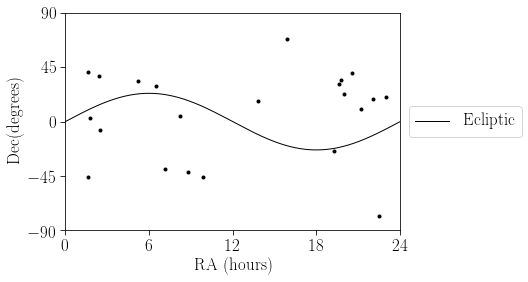

In [10]:
plt.plot(systems.catalogue['ra'][fullInds]*24./360., systems.catalogue['dec'][fullInds], '.', c='k')
x = np.linspace(0,24,1000)
y = 23.43681*np.sin(x*np.pi/12.)
plt.plot(x, y, c='k', lw=1, label=r'$\rm Ecliptic$')
plt.xlabel(r'$\rm RA~(hours)$')
plt.ylabel(r'$\rm Dec (degrees)$')
plt.xticks(np.linspace(0,24,5))
plt.yticks(np.linspace(-90,90,5))
plt.xlim(0,24)
plt.ylim(-90,90)
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.show()

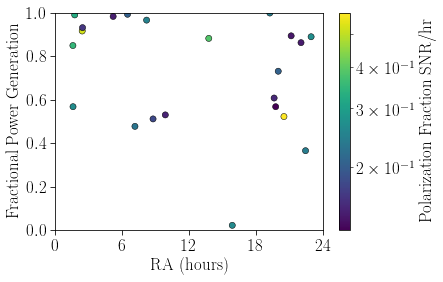

Mean Power Generation: 73% full capacity
Median Power Generation: 86% full capacity


In [11]:
x = systems.catalogue['ra'][fullInds]*24./360.
yEcliptic = 23.43681*np.sin(x*np.pi/12.)
# y = (systems.catalogue['dec'][fullInds] - yEcliptic)
power = np.cos((systems.catalogue['dec'][fullInds] - yEcliptic)*np.pi/180.)

fig = plt.gcf()
ax = plt.gca()

scat = ax.scatter(x=x, y=power, c=SNRs[fullInds], marker='.', s=150, cmap='viridis', norm=colors.LogNorm(), edgecolors='k', linewidth=0.5)
cbar = fig.colorbar(scat, ax=ax, label=r'$\rm Polarization~Fraction~SNR/hr$')
ax.set_xlabel(r'$\rm RA~(hours)$')
ax.set_ylabel(r'$\rm Fractional~Power~Generation$')
ax.set_xticks(np.linspace(0,24,5))
ax.set_xlim(0,24)
ax.set_ylim(0,1)

if savePlots:
    plt.savefig(savepath+'PowerGeneration_vs_RA.png', dpi=300, bbox_inches='tight')

plt.show()

print('Mean Power Generation: '+str(int(np.rint(np.mean(power)*100)))+'% full capacity')
print('Median Power Generation: '+str(int(np.rint(np.median(power)*100)))+'% full capacity')

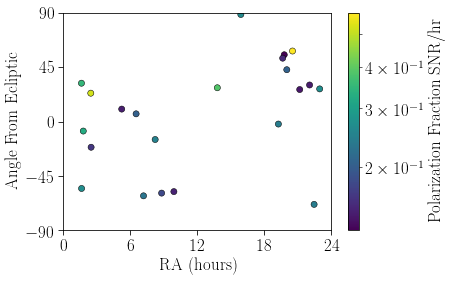

Mean Angle: 37.74 degrees
Median Angle: 31.06 degrees


In [12]:
x = systems.catalogue['ra'][fullInds]*24./360.
yEcliptic = 23.43681*np.sin(x*np.pi/12.)
y = (systems.catalogue['dec'][fullInds] - yEcliptic)

fig = plt.gcf()
ax = plt.gca()

scat = ax.scatter(x=x, y=y, c=SNRs[fullInds], marker='.', s=150, cmap='viridis', norm=colors.LogNorm(), edgecolors='k', linewidth=0.5)
cbar = fig.colorbar(scat, ax=ax, label=r'$\rm Polarization~Fraction~SNR/hr$')
ax.set_xlabel(r'$\rm RA~(hours)$')
ax.set_ylabel(r'$\rm Angle~From~Ecliptic$')
ax.set_xticks(np.linspace(0,24,5))
ax.set_yticks(np.linspace(-90,90,5))
ax.set_xlim(0,24)
ax.set_ylim(-90,90)

# if savePlots:
#     plt.savefig(savepath+'PowerGeneration_vs_RA.png', dpi=300, bbox_inches='tight')

plt.show()

print('Mean Angle: '+str(np.round(np.mean(np.abs(y)), 2))+' degrees')
print('Median Angle: '+str(np.round(np.median(np.abs(y)), 2))+' degrees')

In [13]:
np.percentile(np.abs(y), 15)

11.035278029196945

In [14]:
len(np.where(np.abs(y)<15)[0])/len(y)

0.22727272727272727

In [15]:
np.percentile(power,25)

0.540315854882443

In [16]:
len(np.where(power>0.5)[0])/len(power)

0.8636363636363636

In [17]:
systems.catalogue['name'][fullInds][np.argmin(power)]

'HD 143105 b'

In [18]:
# Ifull = []
# theta = np.linspace(0,360,100)
# for i in theta:
#     Ifull.append(eppe.rayleigh_scatter(i+90))
# Ifull = np.array(Ifull)



# I = Ifull
# x = I*np.cos(theta*np.pi/180)
# y = I*np.sin(theta*np.pi/180)
# plt.plot(x, y)

# I = 0.75*(1+np.cos(theta*np.pi/180)**2)
# x = I*np.cos(theta*np.pi/180)
# y = I*np.sin(theta*np.pi/180)
# plt.plot(x, y)

# plt.show()